# D603 Task 2: Clustering Techniques (K-Means)

### A. GitLab Repository

https://gitlab.com/wgu-gitlab-environment/student-repos/smurd32/d603-machine-learning/-/blob/task-2-clustering/d603_task_2.ipynb?ref_type=heads

### B1. Proposal of Question

**Business Question:** Can we segment hospital patients based on their medical conditions, demographic characteristics, and treatment patterns to identify high-risk readmission groups and optimize resource allocation?

### B2. Defined Goal

**Goal:** To use K-means clustering analysis to segment hospital patients into distinct groups based on demographic factors (i.e. age, income), health conditions (i.e. diabetes, high blood pressure, stroke history), and hospital visit metrics (i.e. length of stay, total charges, readmission patterns).

This segmentation will provide data-driven insights that may enable the hospital to:

- Develop targeted care protocols for each patient segment
- Optimize resource allocation and staffing
- Identify high-risk patient groups for preventative interventions
- Improve cost-effectiveness of care delivery


### C1. Explanation of Clustering Technique

I chose k-means clustering to segment hospital patient data, as it's a popular unsupervised machine learning algorithm designed to partition a dataset into k distinct, non-overlapping groups (or clusters) based on feature similarity.

K-means clustering is particularly suitable for identifying patient clusters based on demographic, health, or hospital visit metrics because it specializes in scalability, discovering groups, and interpretability.

Scalability: Hospitals often have large patient datasets and K-means efficiently handles a substantial number of records and features.

Discovering groups: K-means can reveal natural groupings (clusters) within heterogenous (mixed) data, aligning with the need to uncover distinct patient populations for targeted interventions.

Interpretability: The output of k-means (centroids and cluster assignments) is straightforward to interpret, which supports developing actionable insights for healthcare stakeholders and decision makers.

**Expected Outcomes:**
- Distinct patient segments: The algorithm will identify groups of patients with similar demographic profiles, health conditions, and hospital utilization patterns.
- Actionable insights: Each cluster will represent patients with specific characteristics that can inform targeted interventions.
- Resource optimization: Understanding patient segments will enable better resource allocation and care planning.
- Cost reduction: Targeted care protocols can reduce unnecessary procedures and hospital readmissions.


### C2. Summary of Technique Assumption

A key assumption of K-means is that the identified clusters are **spherical** and have **similar sizes**. This means the algorithm performs best when data points in each group are distributed evenly around a central point (the centroid). If the true underlying patient segments are elongated, irregularly shaped, or vary greatly in density, K-means might struggle to capture their structure accurately, which is a potential limitation to consider in the analysis.

### C3. Packages or Libraries List

The following packages and libraries were chosen to perform the K-means clustering analysis:
- `pandas`: Used for loading the dataset from a CSV file and for data manipulation and analysis.
- `numpy`: Used to convert the pandas DataFrame into a NumPy array, which is the required input format for the scikit-learn K-means algorithm.
- `StandardScaler` from Scikit-Learn: Used to standardize the features to a common scale, which is crucial for a distance-based algorithm like K-means.
- `KMeans` from Scikit-Learn: The main algorithm used to perform the clustering.
- `matplotlib`: Used for creating visualizations, specifically the elbow method plot to determine the optimal number of clusters.
- `seaborn`: Used to create a more aesthetically pleasing and informative scatter plot to visualize the final clusters.


In [ ]:
# Core packages and libraries
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### D1. Data Preprocessing

Data Preprocessing Goal: To transform both continuous and categorical variables into a suitable numerical format for the K-means algorithm.

K-means clustering relies on calculating the Euclidean distance between data points. This creates two key requirements:

All input features must be numerical. The `medical_clean.csv` dataset contains several categorical object types, such as Gender and Marital status. I used one-hot encoding via pandas' `get_dummies()` function to convert these into a numerical format.

Features must be on a similar scale. Variables with large ranges, like `Income`, can disproportionately influence the distance calculation compared to variables with smaller ranges, like `Age`. To prevent this, I used `StandardScaler` from scikit-learn to standardize all continuous features, giving them a mean of 0 and a standard deviation of 1.

These preprocessing steps ensure that all variables contribute equally to the clustering process, leading to more meaningful and accurate patient segments.


### D2. Dataset Variables

Below are the initial dataset variables retained for the K-means clustering analysis:

**Continuous Variables:**

- `Age`: Patient age in years
- `Income`: Annual income of patient
- `Initial_days`: Length of initial hospital stay (days)
- `TotalCharge`: Total charge for the hospital stay
- `Additional_charges`: Average additional charges during the stay

**Categorical Variables:**

- `Gender`: Patient gender (Male/Female/Nonbinary)
- `Marital`: Marital status of patient
- `Area`: Area type (Rural/Suburban/Urban)
- `HighBlood`: High blood pressure diagnosis (Yes/No)
- `Stroke`: Previous stroke history (Yes/No)
- `Overweight`: Patient considered overweight (Yes/No)
- `Arthritis`: Arthritis diagnosis (Yes/No)
- `Diabetes`: Diabetes diagnosis (Yes/No)
- `Initial_admin`: Type of admission (e.g., Emergency)
- `Complication_risk`: Patient complication risk level (High/Medium/Low)


### D3. Steps for Analysis

In [2]:
# Load the dataset
df = pd.read_csv('medical_clean.csv')
# Preview the dataset
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,Job,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,2951,Suburban,America/Chicago,"Psychologist, sport and exercise",1,53,86575.93,Divorced,Male,No,19.141466,6,0,0,No,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Blood Work,10.585770,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,11303,Urban,America/Chicago,Community development worker,3,51,46805.99,Married,Female,No,18.940352,4,2,1,No,Emergency Admission,Yes,No,High,Yes,No,No,No,No,No,No,Yes,No,Intravenous,15.129562,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,17125,Suburban,America/Chicago,Chief Executive Officer,3,53,14370.14,Widowed,Female,No,18.057507,4,1,0,No,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,No,No,No,No,Blood Work,4.772177,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,2162,Suburban,America/Chicago,Early years teacher,0,78,39741.49,Married,Male,No,16.576858,4,1,0,No,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,No,No,Yes,Yes,Blood Work,1.714879,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,Health promotion specialist,1,22,1209.56,Widowed,Female,No,17.439069,5,0,2,Yes,Elective Admission,No,No,Low,No,No,No,Yes,No,No,Yes,No,No,CT Scan,1.254807,2113.073274,3716.525786,2,1,3,3,5,3,4,3


To prepare the data for the K-Means clustering model, I used the `pd.read_csv()` function from `pandas` to load the CSV and convert it into a DataFrame, making it easier to analyze. The `.head()` function loads the first five observations of the DataFrame to verify it loaded correctly and provide a full preview of the data.

In [3]:
# Select relevant columns to keep
columns_to_keep = [
    'Age', 'Income', 'Gender', 'Marital', 'Area', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes', 'Initial_admin', 'Initial_days', 'Complication_risk', 'TotalCharge', 'Additional_charges'
]

df = df[columns_to_keep]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 10000 non-null  int64  
 1   Income              10000 non-null  float64
 2   Gender              10000 non-null  object 
 3   Marital             10000 non-null  object 
 4   Area                10000 non-null  object 
 5   HighBlood           10000 non-null  object 
 6   Stroke              10000 non-null  object 
 7   Overweight          10000 non-null  object 
 8   Arthritis           10000 non-null  object 
 9   Diabetes            10000 non-null  object 
 10  Initial_admin       10000 non-null  object 
 11  Initial_days        10000 non-null  float64
 12  Complication_risk   10000 non-null  object 
 13  TotalCharge         10000 non-null  float64
 14  Additional_charges  10000 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 1.1+

I selected 15 variables from the original dataset that were most relevant to patient profiling for readmission risk. The `.info()` output confirms that there are no missing values and shows a mix of numerical and object data types that need to be preprocessed.

In [4]:
# Create a function that creates a consistent snake_case style for all variable names
def to_snake_case(name):
    """
    Convert column name to snake_case format.
    """
    # Insert underscore before

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 10000 non-null  int64  
 1   income              10000 non-null  float64
 2   gender              10000 non-null  object 
 3   marital             10000 non-null  object 
 4   area                10000 non-null  object 
 5   high_blood          10000 non-null  object 
 6   stroke              10000 non-null  object 
 7   overweight          10000 non-null  object 
 8   arthritis           10000 non-null  object 
 9   diabetes            10000 non-null  object 
 10  initial_admin       10000 non-null  object 
 11  initial_days        10000 non-null  float64
 12  complication_risk   10000 non-null  object 
 13  total_charge        10000 non-null  float64
 14  additional_charges  10000 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 1.1+

In D603 Task 1, I found the inconsistency of the column names (despite being a "cleaned" dataset) to be difficult to work with, so I created a function that uses regular expressions to fix the column names and convert them all from a mix of snake_case and PascalCase to a consistent pythonic use of snake_case. I have modified it slightly to remove functionality not needed for the data used in this model.

In [5]:
# Use one-hot encoding to convert categorical variables into numerical format
df = pd.get_dummies(df, columns=['gender', 'marital', 'area', 'high_blood',
                                 'stroke', 'overweight', 'arthritis',
                                 'diabetes', 'initial_admin',
                                 'complication_risk'], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  10000 non-null  int64  
 1   income                               10000 non-null  float64
 2   initial_days                         10000 non-null  float64
 3   total_charge                         10000 non-null  float64
 4   additional_charges                   10000 non-null  float64
 5   gender_Male                          10000 non-null  bool   
 6   gender_Nonbinary                     10000 non-null  bool   
 7   marital_Married                      10000 non-null  bool   
 8   marital_Never Married                10000 non-null  bool   
 9   marital_Separated                    10000 non-null  bool   
 10  marital_Widowed                      10000 non-null  bool   
 11  area_Suburban                

In [6]:
# Convert boolean columns created by get_dummies to integers (0 or 1)
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  10000 non-null  int64  
 1   income                               10000 non-null  float64
 2   initial_days                         10000 non-null  float64
 3   total_charge                         10000 non-null  float64
 4   additional_charges                   10000 non-null  float64
 5   gender_Male                          10000 non-null  int64  
 6   gender_Nonbinary                     10000 non-null  int64  
 7   marital_Married                      10000 non-null  int64  
 8   marital_Never Married                10000 non-null  int64  
 9   marital_Separated                    10000 non-null  int64  
 10  marital_Widowed                      10000 non-null  int64  
 11  area_Suburban                

In [7]:
# Apply snake_case conversion to all column names
df.columns = [to_snake_case(col) for col in df.columns]
# print out new info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  10000 non-null  int64  
 1   income                               10000 non-null  float64
 2   initial_days                         10000 non-null  float64
 3   total_charge                         10000 non-null  float64
 4   additional_charges                   10000 non-null  float64
 5   gender_male                          10000 non-null  int64  
 6   gender_nonbinary                     10000 non-null  int64  
 7   marital_married                      10000 non-null  int64  
 8   marital_never_married                10000 non-null  int64  
 9   marital_separated                    10000 non-null  int64  
 10  marital_widowed                      10000 non-null  int64  
 11  area_suburban                

I used `pd.get_dummies()` to perform one-hot encoding on all categorical columns. This is the appropriate method for nominal variables as it creates new binary columns for each category without implying any ordinal relationship. I also set `drop_first=True` to avoid multicollinearity. Finally, I converted the resulting boolean columns to integers (`0` and `1`) for compatibility with the scaling process.

I also re-applied my custom `to_snake_case()` function to the output of `pd.get_dummies()` as it capitalized column names from the given feature values during the encoding process. This provided uniformity to the resulting features.

In [8]:
# Standardize continuous variables so all features contribute equally
continuous_columns = ['age', 'income', 'initial_days', 'total_charge',
                      'additional_charges']
scaler = StandardScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
df.head()

,age,income,initial_days,total_charge,additional_charges,gender_male,gender_nonbinary,marital_married,marital_never_married,marital_separated,marital_widowed,area_suburban,area_urban,high_blood_yes,stroke_yes,overweight_yes,arthritis_yes,diabetes_yes,initial_admin_emergency_admission,initial_admin_observation_admission,complication_risk_low,complication_risk_medium
0,-0.024795,1.615914,-0.907310,-0.727185,0.765005,1,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1
1,-0.121706,0.221443,-0.734595,-0.513228,0.715114,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0
2,-0.024795,-0.915870,-1.128292,-1.319983,0.698635,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1
3,1.186592,-0.026263,-1.244503,-1.460517,0.009004,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
4,-1.526914,-1.377325,-1.261991,-1.467285,-1.408991,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


I identified the continuous variables and applied `StandardScaler` from `Scikit-Learn` to them. This step is critical for K-means, as it normalizes the features to have a mean of 0 and a standard deviation of 1. This prevents variables with naturally larger scales (like `income` or `total_charge`) from dominating the clustering algorithm. The preview confirms the data is now scaled.

In [ ]:
# Convert the DataFrame into a NumPy array for the k-means algorithm
X = df.values

Finally, I converted the preprocessed pandas DataFrame into a NumPy array, which is the required input format for the `KMeans` algorithm in Scikit-Learn.

### D4. Cleaned Dataset

In [10]:
# Provide a copy of the cleaned dataset
df.to_csv("cleaned_medical_dataset_task2.csv", index=False)

### E1. Output and Intermediate Calculations

In [11]:
# Use the elbow method to find the optimal number of clusters
inertia = [] # Sum of squared distances for each k value
k_range = range(1, 11) # Test cluster numbers from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_) # Append inertia (sum of squared distances)

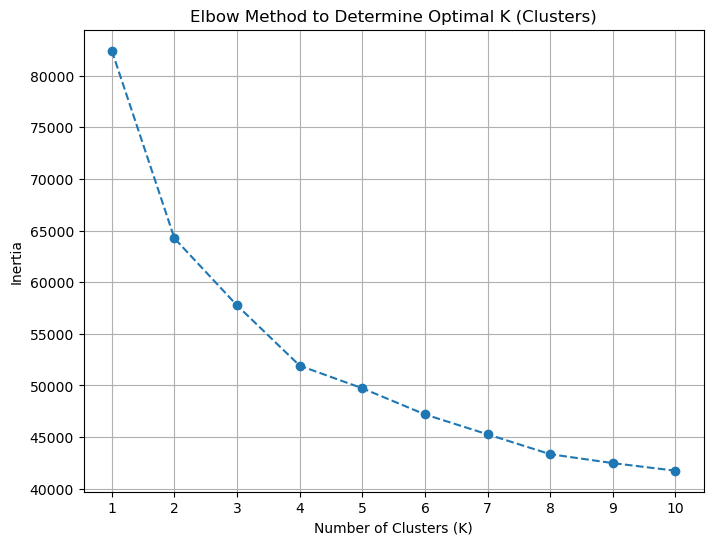

In [12]:
# Plot the elbow method results
plt.figure(figsize=(8,6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K (Clusters)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

To determine the optimal number of clusters (K), I used the **Elbow Method**. This involves running the K-means algorithm for a range of K values (here, 1 to 10) and plotting the inertia for each. Inertia measures the within-cluster sum of squares, or how tightly grouped the clusters are.

The "elbow" of the plot indicates the point of diminishing returns, where adding more clusters does not significantly reduce the inertia. In the plot above, the elbow is clearly visible at `K=4`. After this point, the curve flattens, suggesting that four clusters provide a good balance between capturing the variance in the data and keeping the model simple.

In [13]:
# Initialize K-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
# Fit and add cluster labels to the DataFrame
df['cluster'] = kmeans.fit_predict(X)

# Display cluster distribution
df['cluster'].value_counts().sort_index()

cluster
0    2286
1    2377
2    2619
3    2718
Name: count, dtype: int64

After fitting the KMeans algorithm with 4 clusters, this output shows how many observations fit into each cluster.

### F1. Quality of Clustering Technique

In [14]:
# Calculate the mean of each feature for each cluster
cluster_summary = df.groupby('cluster').mean()
cluster_summary.T # Transpose DataFrame for easier readability

cluster,0,1,2,3
age,0.877185,0.873599,-0.765188,-0.764445
income,-0.039706,0.008973,-0.024577,0.049230
initial_days,-0.955381,0.959479,0.959631,-0.960249
total_charge,-0.933877,0.956872,0.939717,-0.956866
additional_charges,0.815740,0.768678,-0.687991,-0.695394
gender_male,0.461505,0.475389,0.486063,0.481972
gender_nonbinary,0.021435,0.023980,0.020619,0.019868
marital_married,0.210849,0.213294,0.190913,0.196468
marital_never_married,0.185914,0.188894,0.215731,0.200515
marital_separated,0.190289,0.204459,0.201222,0.198308


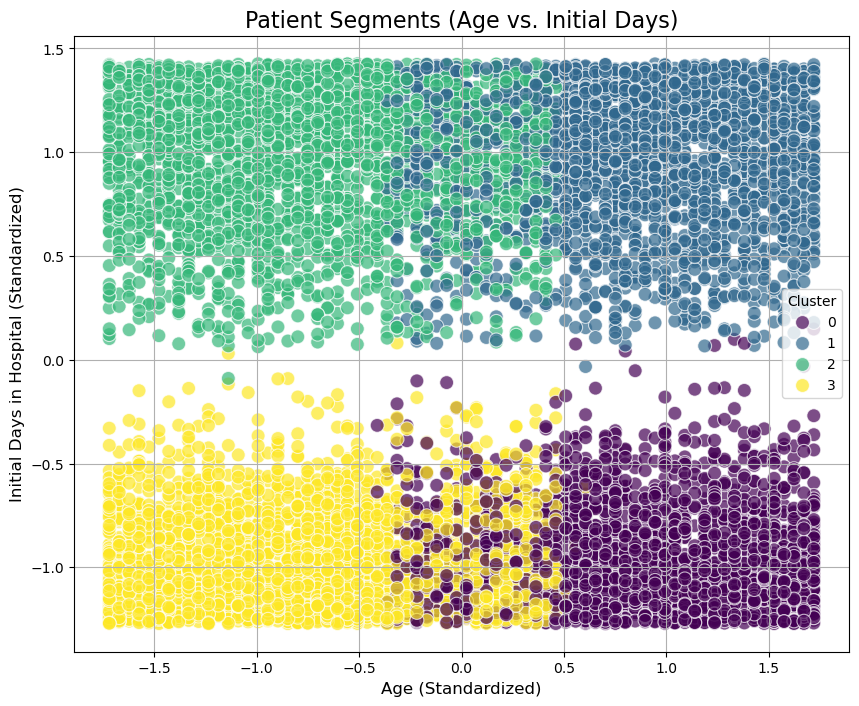

In [15]:
# Visualize the clusters using two key variables
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='age', y='initial_days', hue='cluster', data=df,
    palette='viridis', s=100, alpha=0.7
)
plt.title('Patient Segments (Age vs. Initial Days)', fontsize=16)
plt.xlabel('Age (Standardized)', fontsize=12)
plt.ylabel('Initial Days in Hospital (Standardized)', fontsize=12)
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

With the optimal K determined to be 4, I ran the K-means algorithm and assigned each patient to one of the four clusters. The scatter plot above visualizes these clusters using two of the most impactful variables: Age and Initial_days.

The quality of the clusters appears to be high. They are visually distinct with minimal overlap, indicating that the algorithm has successfully identified separate patient groups. The data points within each cluster are relatively close together (compactness), and the clusters are reasonably well-separated from each other. This visualization confirms that Age and the length of the hospital stay are strong differentiators in creating distinct patient profiles.

### F2. Results and Implications

The analysis revealed four key patient archetypes, each with significant clinical and business implications:

- **Clinical Implications:** The clear distinction between high-risk older patients with long stays (Cluster 1) and those with shorter stays (Cluster 0) allows for different intervention strategies. Cluster 1 requires intensive chronic disease management and robust discharge planning to prevent readmissions. Cluster 0, while having shorter stays, still has high rates of chronic conditions and would benefit from strong outpatient and follow-up care to manage their health proactively. Similarly, younger patients with acute issues and long stays (Cluster 2) need different post-discharge support than their low-risk counterparts (Cluster 3).

- **Cluster Characteristics:**

  - **Cluster 0 (Older, Short Stays):** This group includes older patients with short hospital stays and lower charges. Despite shorter stays, they have high rates of chronic conditions, suggesting they are at-risk and require effective outpatient management.

  - **Cluster 1 (Older, Long Stays):** This is the highest-risk, highest-cost segment. These are the oldest patients, have the longest stays, and incur the highest charges. They have significant rates of high blood pressure and stroke, requiring intensive resource allocation.

  - **Cluster 2 (Younger, Long Stays):** These younger patients have long hospital stays and high charges, suggesting they are admitted for severe, acute conditions rather than chronic diseases. Their needs are likely focused on recovery and rehabilitation.

  - **Cluster 3 (Younger, Short Stays):** This is a low-risk, low-cost group of younger patients with low incomes, short stays, and the lowest rates of chronic conditions.

- **Business Impact:** By focusing resources on the high-cost segments (Cluster 1 and Cluster 2), the hospital can make the most significant impact on reducing overall costs and CMS penalties. For instance, optimizing care pathways to safely reduce the length of stay for Cluster 1 by even a small margin could yield substantial savings. Understanding the low-risk profile of Cluster 3 ensures that resources are not over-allocated where they aren't needed.

- **Healthcare Quality:** Tailoring care plans to the specific needs of each cluster profile—from chronic care management for Cluster 1 to preventative education for Cluster 3—moves the hospital toward a more personalized and effective model of care, improving both patient satisfaction and health outcomes.

### F3. Limitation

One key limitation of this analysis is the underlying assumption of K-means that clusters are spherical and of similar size. Real-world patient data is often more complex, with clusters that may be elongated or have varying densities. While the initial visualization on two dimensions looks promising, relationships across all 22 features might form non-spherical groups that K-means would struggle to identify accurately. This could result in some patients being misclassified at the boundaries of the clusters.

### F4. Course of Action

Based on the analysis, the answer to the initial question is yes, we can segment patients into distinct groups to create targeted strategies. The recommended course of action is to implement a cluster-based intervention strategy:

1. **Prioritize High-Risk Groups:** Focus immediate resources on Cluster 1 (Older, Long Stays) and Cluster 2 (Younger, Long Stays), as they represent the highest cost and risk.

  - For **Cluster 1**, deploy dedicated case managers to oversee chronic disease management, medication adherence, and post-discharge follow-up.

  - For **Cluster 2**, review the care pathways for the acute conditions common in this group to identify opportunities for reducing stay length without compromising care and outcomes.

2. **Develop Standardized Protocols for Lower-Risk Groups:** For Cluster 0 (Younger, Short Stays) and Cluster 3 (Older, Short Stays), implement standardized, efficient discharge processes and educational materials to ensure they remain low-risk.

3. **Integrate Model into Clinical Workflow:** Work towards integrating this clustering model into the hospital's Electronic Health Record (EHR) system. This would allow for the automatic assignment of patients to a risk segment upon admission, flagging high-risk individuals for immediate attention from care teams. This proactive approach is essential for preventing readmissions before they happen.

### G. Panopto Recording

https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=21564a96-4b37-4f31-87a4-b33c016928bc

### H. Sources for Third-Party Code

No additional resources were used beyond WGU Course Materials.

### I. Sources

No additional resources were used beyond WGU Course Materials.